In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/train"
val_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/val"
test_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/test"

Mounted at /content/drive


In [3]:
torch.manual_seed(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),   ## Resize the images to 256x256
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   ## Adding random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),   ## adding random flips left and right
    transforms.RandomVerticalFlip(p=0.5), ## vertical
    transforms.RandomRotation(5),  ## adding random +- 10
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   ## Adding a little brigthness
    transforms.ToTensor(),  ## converting the images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ## normalizzing according to resnet34 mean and std values
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [6]:
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)  ## used val and text transformer for 2 dataset

In [7]:
print(len(train_dataset))

print(len(val_dataset))
print(len(test_dataset))

## 8010 + 998 + 1007 = 1000015

8010
998
1007


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
model = models.resnet50(pretrained=True)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


In [10]:
for param in model.parameters():
    param.requires_grad = False

In [11]:
model.fc = nn.Linear(model.fc.in_features, 7)

model = model.to(device)

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum()


In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


criterion = FocalLoss(alpha=0.25, gamma=2.0)

optimizer = optim.Adam(
    model.fc.parameters(),
    lr=1e-4,
    weight_decay=3e-6
)


scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    patience=3,
    factor=0.5
)

In [ ]:
from sklearn.metrics import f1_score
from tqdm import tqdm

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores = []

epochs = 30
best_f1 = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 40)
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    # ================= TRAINING ==================
    for imgs, labels in tqdm(train_loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ================= VALIDATION ==================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Step the LR scheduler based on F1 (since mode='max')
    scheduler.step(val_f1)

    # ================= SAVE BEST MODEL ==================
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/resnet50_best.pth")
        print("✅ Model improved and saved!")

print("\n🎯 Training Complete!")
print(f"Best Validation F1-score: {best_f1:.4f}")



Epoch 1/30
----------------------------------------


Training: 100%|██████████| 126/126 [10:12<00:00,  4.86s/it]


Train Loss: 0.1714 | Train Acc: 0.6521


Validating: 100%|██████████| 16/16 [01:19<00:00,  4.95s/it]


Val Loss: 0.1493 | Val Acc: 0.6743 | Val F1: 0.5592
✅ Model improved and saved!

Epoch 2/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:57<00:00,  1.07it/s]


Train Loss: 0.1395 | Train Acc: 0.6809


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


Val Loss: 0.1322 | Val Acc: 0.6984 | Val F1: 0.6222
✅ Model improved and saved!

Epoch 3/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:48<00:00,  1.16it/s]


Train Loss: 0.1281 | Train Acc: 0.6953


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Val Loss: 0.1207 | Val Acc: 0.7134 | Val F1: 0.6435
✅ Model improved and saved!

Epoch 4/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:47<00:00,  1.17it/s]


Train Loss: 0.1214 | Train Acc: 0.7029


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Val Loss: 0.1136 | Val Acc: 0.7255 | Val F1: 0.6657
✅ Model improved and saved!

Epoch 5/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:47<00:00,  1.17it/s]


Train Loss: 0.1172 | Train Acc: 0.7155


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


Val Loss: 0.1099 | Val Acc: 0.7385 | Val F1: 0.7053
✅ Model improved and saved!

Epoch 6/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:49<00:00,  1.16it/s]


Train Loss: 0.1108 | Train Acc: 0.7242


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


Val Loss: 0.1065 | Val Acc: 0.7315 | Val F1: 0.6924

Epoch 7/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:49<00:00,  1.15it/s]


Train Loss: 0.1069 | Train Acc: 0.7267


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


Val Loss: 0.1024 | Val Acc: 0.7485 | Val F1: 0.7110
✅ Model improved and saved!

Epoch 8/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Train Loss: 0.1043 | Train Acc: 0.7330


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


Val Loss: 0.1004 | Val Acc: 0.7545 | Val F1: 0.7276
✅ Model improved and saved!

Epoch 9/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:47<00:00,  1.18it/s]


Train Loss: 0.1027 | Train Acc: 0.7348


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Val Loss: 0.0993 | Val Acc: 0.7475 | Val F1: 0.7127

Epoch 10/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.0995 | Train Acc: 0.7383


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


Val Loss: 0.0980 | Val Acc: 0.7515 | Val F1: 0.7351
✅ Model improved and saved!

Epoch 11/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Train Loss: 0.0993 | Train Acc: 0.7388


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.0956 | Val Acc: 0.7575 | Val F1: 0.7357
✅ Model improved and saved!

Epoch 12/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Train Loss: 0.0979 | Train Acc: 0.7437


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


Val Loss: 0.0955 | Val Acc: 0.7605 | Val F1: 0.7326

Epoch 13/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.0963 | Train Acc: 0.7448


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]


Val Loss: 0.0948 | Val Acc: 0.7545 | Val F1: 0.7321

Epoch 14/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.0927 | Train Acc: 0.7568


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Val Loss: 0.0945 | Val Acc: 0.7595 | Val F1: 0.7397
✅ Model improved and saved!

Epoch 15/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:46<00:00,  1.19it/s]


Train Loss: 0.0940 | Train Acc: 0.7474


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


Val Loss: 0.0929 | Val Acc: 0.7535 | Val F1: 0.7297

Epoch 16/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:47<00:00,  1.18it/s]


Train Loss: 0.0936 | Train Acc: 0.7492


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


Val Loss: 0.0929 | Val Acc: 0.7625 | Val F1: 0.7448
✅ Model improved and saved!

Epoch 17/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:52<00:00,  1.12it/s]


Train Loss: 0.0924 | Train Acc: 0.7517


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


Val Loss: 0.0926 | Val Acc: 0.7685 | Val F1: 0.7473
✅ Model improved and saved!

Epoch 18/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:52<00:00,  1.12it/s]


Train Loss: 0.0907 | Train Acc: 0.7518


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


Val Loss: 0.0909 | Val Acc: 0.7655 | Val F1: 0.7365

Epoch 19/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:51<00:00,  1.13it/s]


Train Loss: 0.0907 | Train Acc: 0.7533


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


Val Loss: 0.0904 | Val Acc: 0.7675 | Val F1: 0.7435

Epoch 20/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:52<00:00,  1.12it/s]


Train Loss: 0.0904 | Train Acc: 0.7522


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


Val Loss: 0.0919 | Val Acc: 0.7625 | Val F1: 0.7338

Epoch 21/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:50<00:00,  1.14it/s]


Train Loss: 0.0903 | Train Acc: 0.7553


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.0905 | Val Acc: 0.7675 | Val F1: 0.7506
✅ Model improved and saved!

Epoch 22/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:52<00:00,  1.12it/s]


Train Loss: 0.0885 | Train Acc: 0.7619


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


Val Loss: 0.0897 | Val Acc: 0.7725 | Val F1: 0.7482

Epoch 23/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:52<00:00,  1.12it/s]


Train Loss: 0.0881 | Train Acc: 0.7624


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


Val Loss: 0.0903 | Val Acc: 0.7705 | Val F1: 0.7474

Epoch 24/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:51<00:00,  1.13it/s]


Train Loss: 0.0882 | Train Acc: 0.7573


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


Val Loss: 0.0896 | Val Acc: 0.7625 | Val F1: 0.7361

Epoch 25/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:52<00:00,  1.12it/s]


Train Loss: 0.0861 | Train Acc: 0.7588


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


Val Loss: 0.0911 | Val Acc: 0.7665 | Val F1: 0.7444

Epoch 26/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:51<00:00,  1.13it/s]


Train Loss: 0.0858 | Train Acc: 0.7630


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


Val Loss: 0.0891 | Val Acc: 0.7665 | Val F1: 0.7494

Epoch 27/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:53<00:00,  1.11it/s]


Train Loss: 0.0858 | Train Acc: 0.7620


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


Val Loss: 0.0890 | Val Acc: 0.7685 | Val F1: 0.7459

Epoch 28/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:54<00:00,  1.10it/s]


Train Loss: 0.0852 | Train Acc: 0.7650


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


Val Loss: 0.0888 | Val Acc: 0.7715 | Val F1: 0.7518
✅ Model improved and saved!

Epoch 29/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:54<00:00,  1.10it/s]


Train Loss: 0.0846 | Train Acc: 0.7635


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


Val Loss: 0.0891 | Val Acc: 0.7685 | Val F1: 0.7459

Epoch 30/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Train Loss: 0.0857 | Train Acc: 0.7599


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]

Val Loss: 0.0882 | Val Acc: 0.7665 | Val F1: 0.7404

🎯 Training Complete!
Best Validation F1-score: 0.7518


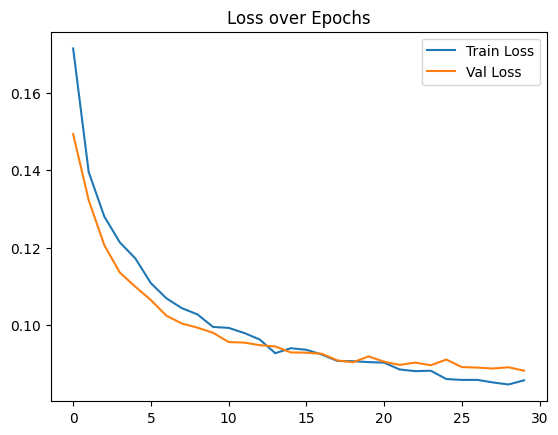

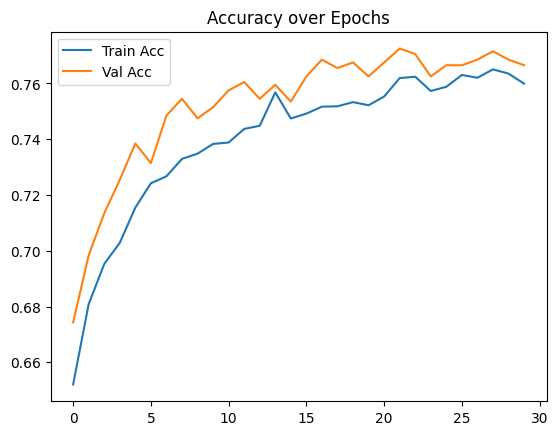

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import json
import numpy as np

# ==============================
# 1️⃣ Load Best Model
# ==============================
model.load_state_dict(torch.load("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/resnet50_best.pth", map_location=device))
model.eval()

# ==============================
# 2️⃣ Evaluate on Test Set
# ==============================
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==============================
# 3️⃣ Compute Metrics
# ==============================
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"\n📊 Test Accuracy: {test_acc:.4f}")
print(f"📈 Test F1-score: {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# ==============================
# 4️⃣ Save Metrics for Ensemble Weighting
# ==============================
metrics = {
    "model": "resnet50",
    "test_accuracy": float(test_acc),
    "test_f1": float(test_f1)
}

with open("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Results/metrics_resnet50.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("\n✅ Metrics saved to metrics_resnet50.json")


Testing: 100%|██████████| 16/16 [01:39<00:00,  6.24s/it]



📊 Test Accuracy: 0.7646
📈 Test F1-score: 0.7477

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.15      0.23        34
           1       0.46      0.54      0.50        52
           2       0.53      0.55      0.54       111
           3       0.00      0.00      0.00        12
           4       0.59      0.43      0.49       112
           5       0.85      0.93      0.89       671
           6       0.70      0.47      0.56        15

    accuracy                           0.76      1007
   macro avg       0.52      0.44      0.46      1007
weighted avg       0.74      0.76      0.75      1007


✅ Metrics saved to metrics_resnet50.json


AttributeError: 'ResNet' object has no attribute 'load'

TypeError: 'ellipsis' object is not iterable

NameError: name 'val_losses_model1' is not defined

<Figure size 1000x500 with 0 Axes>